[Hierarchical Time Series Using PyMC](https://charlescopley.medium.com/heirarchical-time-series-using-pymc-29acd6a7c401)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# Simulating some data
np.random.seed(0)

n_groups      = 3  # number of groups
n_data_points = 100  # number of data points per group

x               = np.tile(np.linspace(0, 10, n_data_points), n_groups)
group_indicator = np.repeat(np.arange(n_groups), n_data_points)
slope_true      = np.random.normal(0, 1, size=n_groups)
intercept_true  = np.random.normal(2, 1, size=n_groups)

y = slope_true[group_indicator]*x + intercept_true[group_indicator] + np.random.normal(0, 1, size=n_groups*n_data_points)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
x.shape

(300,)

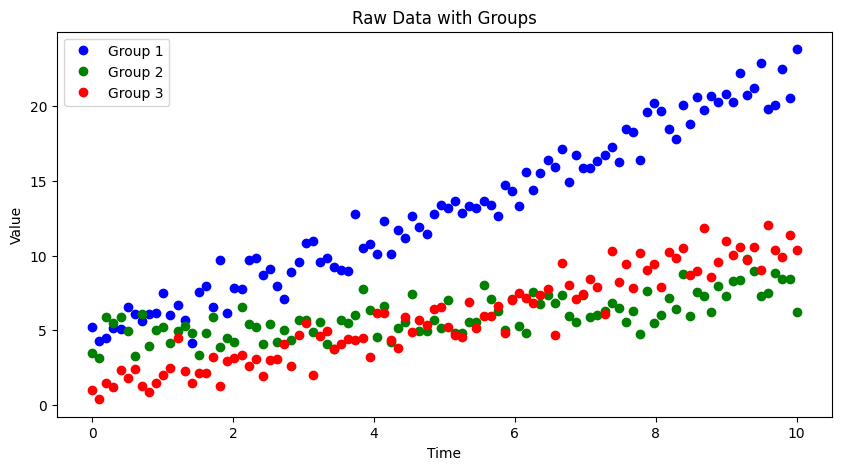

In [4]:
colors = ['b', 'g', 'r']  # Define different colors for each group

plt.figure(figsize=(10, 5))

# Plot raw data for each group
for i in range(n_groups):
    plt.plot(x[group_indicator == i], y[group_indicator == i], 'o', color=colors[i], label=f'Group {i+1}')

plt.title('Raw Data with Groups')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
hierarchical_model = pm.Model()

with hierarchical_model:
    # Hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=10)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
  
    # Priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_groups)  # group-specific intercepts
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_groups)  # group-specific slopes
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value
    mu = alpha[group_indicator] + beta[group_indicator] * x

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

In [10]:
with hierarchical_model:
    # Sampling
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 152 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


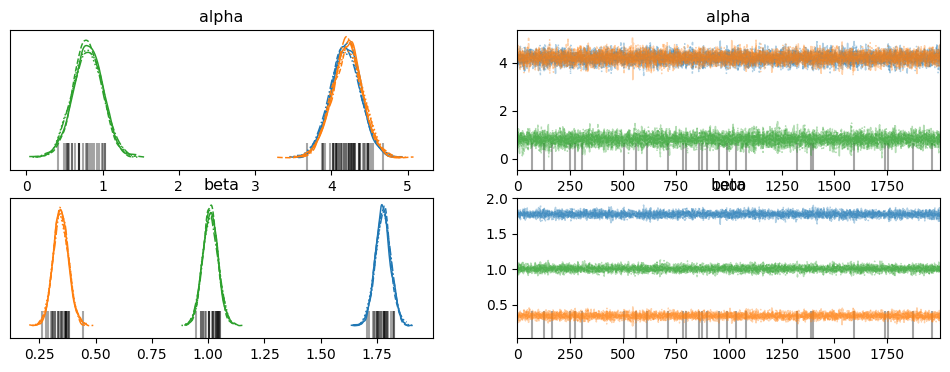

In [11]:
# Checking the trace
pm.plot_trace(trace,var_names=['alpha','beta'])
plt.show()

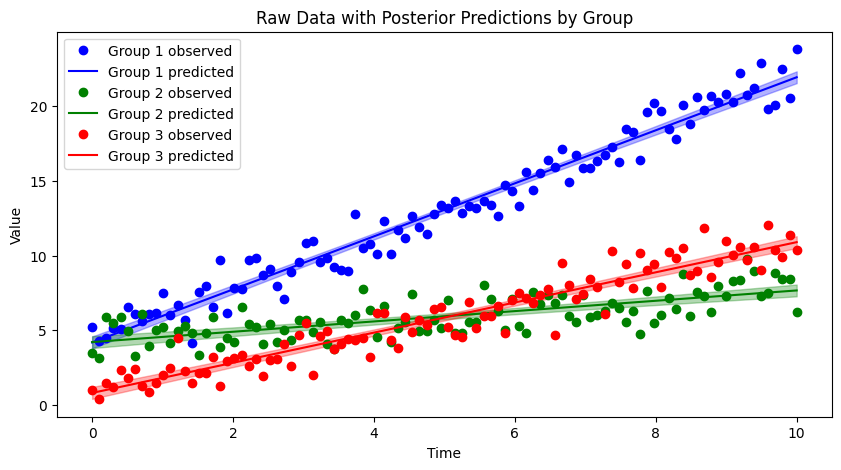

In [12]:
# Posterior samples
alpha_samples = trace.posterior['alpha'].values
beta_samples = trace.posterior['beta'].values

# New x values for predictions
x_new = np.linspace(0, 10, 200)

plt.figure(figsize=(10, 5))

# Plot raw data and predictions for each group
for i in range(n_groups):
    # Plot raw data
    
    plt.plot(x[group_indicator == i], y[group_indicator == i], 'o', color=colors[i], label=f'Group {i+1} observed')
    x_new = x[group_indicator == i]
    # Generate and plot predictions
    alpha = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['alpha'].values
    beta = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['beta'].values
    y_hat = alpha[..., None] + beta[..., None] * x_new[None,:]
    y_hat_mean = y_hat.mean(axis=(0, 1))
    y_hat_std = y_hat.std(axis=(0, 1))
    plt.plot(x_new, y_hat_mean, color=colors[i], label=f'Group {i+1} predicted')
    plt.fill_between(x_new, y_hat_mean - 2*y_hat_std, y_hat_mean + 2*y_hat_std, color=colors[i], alpha=0.3)

plt.title('Raw Data with Posterior Predictions by Group')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()